In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

# Paths and data
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_6000.npz", allow_pickle=True, mmap_mode='r')
nonmutated_data = np.load("/content/EAUGMENTED_DATA_TRAINING_6000.npz", allow_pickle=True, mmap_mode='r')

# Load sequences function
def load_sequences(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:  # If 2D, reshape to 3D for LSTM
            temp_sequences = np.expand_dims(temp_sequences, axis=1)  # (samples, 1, features)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            break
    return encoded_sequences

# Load mutated and non-mutated sequences
mutated_sequences = load_sequences(mutated_data)
nonmutated_sequences = load_sequences(nonmutated_data)

# Labels
mutated_labels = np.ones(mutated_sequences.shape[0])  # 1 for mutated
nonmutated_labels = np.zeros(nonmutated_sequences.shape[0])  # 0 for non-mutated

# Step 1: Split data into train, validation, and test sets
X_mutated_train, X_mutated_temp, y_mutated_train, y_mutated_temp = train_test_split(
    mutated_sequences, mutated_labels, test_size=0.4, random_state=42)  # 60% train, 40% temp
X_nonmutated_train, X_nonmutated_temp, y_nonmutated_train, y_nonmutated_temp = train_test_split(
    nonmutated_sequences, nonmutated_labels, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Split temp into validation and test sets (50% validation, 50% test)
X_mutated_val, X_mutated_test, y_mutated_val, y_mutated_test = train_test_split(
    X_mutated_temp, y_mutated_temp, test_size=0.5, random_state=42)  # 50% validation, 50% test
X_nonmutated_val, X_nonmutated_test, y_nonmutated_val, y_nonmutated_test = train_test_split(
    X_nonmutated_temp, y_nonmutated_temp, test_size=0.5, random_state=42)  # 50% validation, 50% test

# Combine mutated and non-mutated data for training, validation, and testing
X_train = np.concatenate([X_mutated_train, X_nonmutated_train], axis=0)
y_train = np.concatenate([y_mutated_train, y_nonmutated_train], axis=0)

X_val = np.concatenate([X_mutated_val, X_nonmutated_val], axis=0)
y_val = np.concatenate([y_mutated_val, y_nonmutated_val], axis=0)

X_test = np.concatenate([X_mutated_test, X_nonmutated_test], axis=0)
y_test = np.concatenate([y_mutated_test, y_nonmutated_test], axis=0)

# Shuffle data (for randomness)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)



In [14]:
def get_anomaly_scores(X_train):
    # Flatten data for anomaly detection (to use in Isolation Forest)
    flattened_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D

    clf = IsolationForest(contamination=0.01, random_state=42)
    clf.fit(flattened_train)  # Train on the training data

    # Get anomaly scores for training data
    anomaly_scores_train = clf.decision_function(flattened_train)
    inverted_anomaly_scores_train = -anomaly_scores_train  # Invert so higher scores mean more "normal"

    return inverted_anomaly_scores_train, clf

# Get anomaly scores for the training set
anomaly_scores_train, clf = get_anomaly_scores(X_train)

# Step 3: Add anomaly scores to training data (reshape to 3D for compatibility with LSTM)
anomaly_scores_train_reshaped = anomaly_scores_train.reshape(-1, 1, 1)  # Shape (samples, 1, 1)

# Add anomaly scores to the last feature dimension of the sequences (3D data for LSTM)
X_train_with_anomalies = np.concatenate([X_train, anomaly_scores_train_reshaped], axis=-1)

# Step 4: Apply the trained model on the test data (without leaking data)
def get_test_anomaly_scores(X_test, clf):
    flattened_test = X_test.reshape(X_test.shape[0], -1)  # Flatten to 2D
    anomaly_scores_test = clf.decision_function(flattened_test)
    inverted_anomaly_scores_test = -anomaly_scores_test  # Invert scores
    return inverted_anomaly_scores_test

# Get anomaly scores for the test set
anomaly_scores_test = get_test_anomaly_scores(X_test, clf)

# Add anomaly scores to the test data (reshape to 3D)
anomaly_scores_test_reshaped = anomaly_scores_test.reshape(-1, 1, 1)  # Shape (samples, 1, 1)

# Add anomaly scores to the test data sequences
X_test_with_anomalies = np.concatenate([X_test, anomaly_scores_test_reshaped], axis=-1)


In [6]:
checkpoint_path = "E:/my_models/750_if_new_best_model.weights.h5"

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training fold 1
Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.6505 - loss: 4.6741
Epoch 1: val_loss improved from inf to 0.38885, saving model to checkpoint_fold1.weights.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 98s 790ms/step - accuracy: 0.6510 - loss: 4.6576 - val_accuracy: 0.9677 - val_loss: 0.3889
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.6925 - loss: 0.8244
Epoch 2: val_loss improved from 0.38885 to 0.38536, saving model to checkpoint_fold1.weights.h5
120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 777ms/step - accuracy: 0.6922 - loss: 0.8241 - val_accuracy: 0.9120 - val_loss: 0.3854
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.6523 - loss: 0.7003
Epoch 3: val_loss did not improve from 0.38536
120/120 ━━━━━━━━━━━━━━━━━━━━ 87s 722ms/step - accuracy: 0.6523 - loss: 0.7003 - val_accuracy: 0.9109 - val_loss: 0.4117
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.6766 - loss: 0.6101
Epoch 4: val_loss did not improve

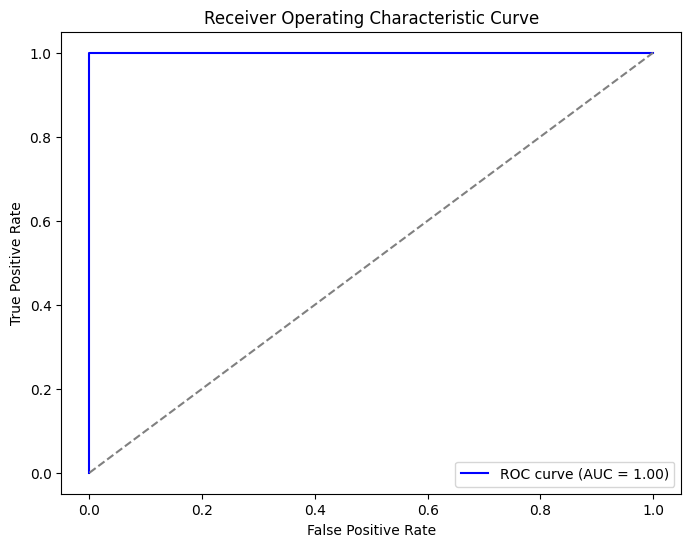

In [11]:

# Now we have 80% training, 10% validation, and 10% test

# RNN Model
def rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True, activation="relu"),
        Dropout(0.5),  # First dropout layer

        LSTM(32, activation="relu", return_sequences=False),
        Dropout(0.5),  # Second dropout layer

        Dense(16, activation="relu"),
        Dropout(0.5),  # Third dropout layer

        Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))  # Output layer
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model
input_shape = input_shape=(X_train_with_anomalies.shape[1], X_train_with_anomalies.shape[2])
# Train the model
model = rnn_model(input_shape)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
csv_logger = CSVLogger("training_log_6000.csv")

history = model.fit(X_train_with_anomalies, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val),
                    callbacks=[checkpoint, csv_logger])

# Evaluate the model
y_pred = model.predict(X_test_with_anomalies)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Evaluate model performance
print(classification_report(y_test, y_pred_classes))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 0.1179
Test Accuracy: 1.0000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

🔹 First 10 Predictions vs Actual Values 🔹
Sample 1: Actual = 0.0, Predicted Probability = 0.2068
Sample 2: Actual = 0.0, Predicted Probability = 0.2068
Sample 3: Actual = 1.0, Predicted Probability = 1.0000
Sample 4: Actual = 0.0, Predicted Probability = 0.2068
Sample 5: Actual = 0.0, Predicted Probability = 0.2068
Sample 6: Actual = 0.0, Predicted Probability = 0.2068
Sample 7: Actual = 0.0, Predicted Probability = 0.2068
Sample 8: Actual = 1.0, Predicted Probability = 1.0000
Sample 9: Actual = 0.0, Predicted Probability = 0.2068
Sample 10: Actual = 0.0, Predicted Probability = 0.2068


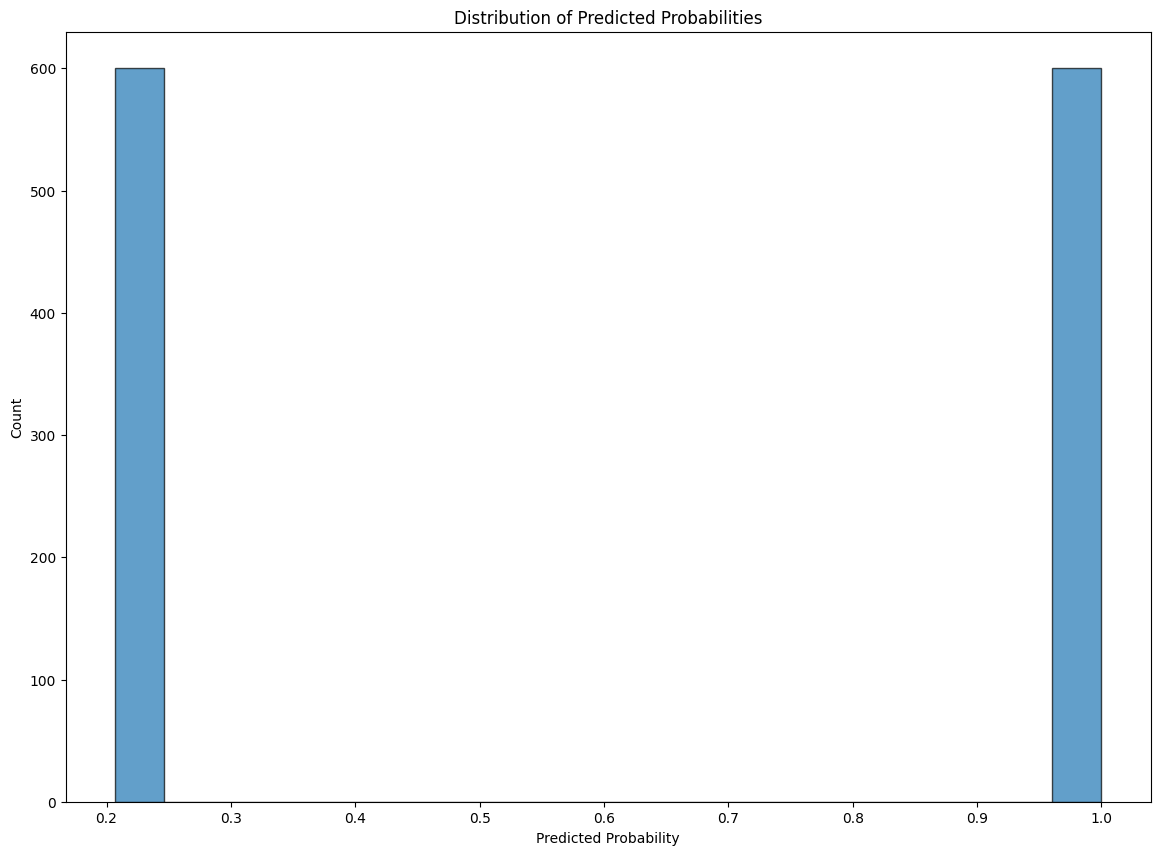

Area Under the Curve (AUC): 1.0000

Classification Report:              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       600
         1.0       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



NameError: name 'plot_learning_curve' is not defined

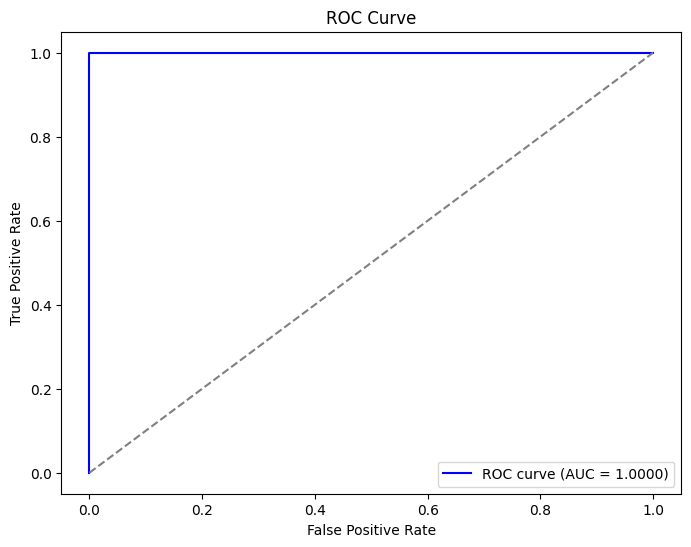

In [12]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model.predict(x_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

# Save plots
os.makedirs(save_path, exist_ok=True)

# Histogram of predictions
plt.figure(figsize=(14, 10))
plt.hist(predictions, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities")
plt.savefig(save_path + "histogram_predictions.png")
plt.show()

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(save_path + "750_new_if_roc_curve.png")

print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

# Classification report
report = classification_report(y_test, (predictions > 0.5).astype(int))
print("\nClassification Report:" + report)
report = classification_report(y_test, (predictions > 0.5).astype(int), output_dict=True)

# Convert the dictionary into a DataFrame and transpose it
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv("750_new_if_classification_report.csv")

# Plot learning curves
plot_learning_curve(rnn_fit, save_path="750_new_if_learning_curve")


In [ ]:
import shap
explainer = shap.Explainer(model, input_data)

# Calculate SHAP values for the input data
shap_values = explainer(input_data)






In [ ]:
shap.summary_plot(shap_values, input_data)

In [ ]:
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(shap_values[0], input_data[0]

In [ ]:
shap.dependence_plot("feature_name", shap_values, input_data)

In [ ]:
shap.waterfall_plot(shap_values[0])